### 优化

从一个现象入手

epoch 23, x1 -0.734666, x2 0.000024


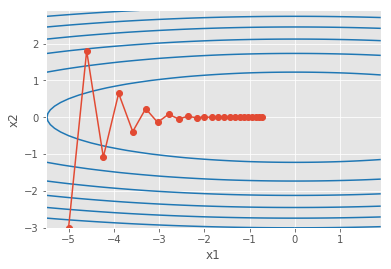

In [48]:
eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

def train_2d(trainer):
    x1, x2 = -5, -3
    s1, s2 = 0, 0
    ret = [(x1, x2)]
    for i in range(23):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        ret.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i+1, x1, x2))
    return ret

def show_trace_2d(f, res):
    x1, x2 = zip(*res)
    plt.plot(x1, x2, '-o')
    x1 = np.arange(-5.5, 2.0, 0.1)
    x2 = np.arange(-3.0, 3.0, 0.1)
    x1, x2 = np.meshgrid(x1, x2)
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
optimi = train_2d(gd_2d)
show_trace_2d(f_2d, optimi)

目标函数在竖直方向（ $x_2$ 轴）比在水平方向（ $x_1$ 轴）的斜率的绝对值更大，给定学习率，梯度下降迭代自变量时会使自变量在竖直方向比在水平方向移动幅度更大。在水平方向，自变量趋于最优值；而竖直方向，自变量在最优值附近抖动。

更小的学习率可以避免在竖直方向的抖动，但在水平方向优化变慢。更大学习率会在竖直方向抖动更厉害，甚至overshoot.

epoch 23, x1 -4.774990, x2 -1.173166


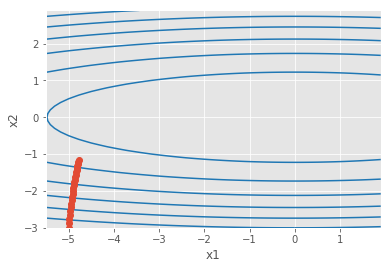

In [49]:
eta = 0.01
show_trace_2d(f_2d, train_2d(gd_2d))

epoch 23, x1 -0.155752, x2 2230431.408421


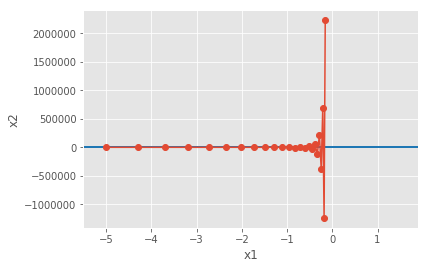

In [50]:
eta = 0.7
show_trace_2d(f_2d, train_2d(gd_2d))

解决思路：

1. 竖直方向和水平方向使用不同的学习率；

2. 竖直方向平滑时，当前优化方向包括了之前各次的优化的和，正负方向抵消，就不会抖动。

### 动量法（momentum）

加入系数$\gamma$，$\gamma$乘以历史梯度和，$1-\gamma$乘以当前梯度

epoch 23, x1 -1.143556, x2 -0.167433


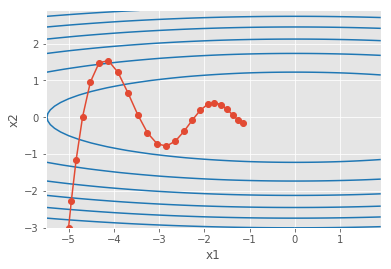

In [58]:
eta, gamma = 0.3, 0.8

def momentum_2d(x1, x2, h1, h2):
    h1 = gamma * h1 + (1 - gamma) * eta * 0.2 * x1
    h2 = gamma * h2 + (1 - gamma) * eta * 4 * x2
    return (x1 - h1, x2 - h2, h1, h2)

show_trace_2d(f_2d, train_2d(momentum_2d))

#### 指数加权移动平均（expontentially weighted moving average）

给定超参数$0 \leq \gamma < 1$，当前时间步$t$的变量$y_t$是上一时间步$t-1$的变量$y_{t-1}$和当前时间步另一变量$x_t$的线性组合：

$$y_t = \gamma y_{t-1} + (1-\gamma) x_t.$$

我们可以对$y_t$展开：

$$
\begin{aligned}
y_t  &= (1-\gamma) x_t + \gamma y_{t-1}\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + \gamma^2y_{t-2}\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + (1-\gamma) \cdot \gamma^2x_{t-2} + \gamma^3y_{t-3}\\
         &\ldots\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + (1-\gamma) \cdot \gamma^2x_{t-2} + \ldots + (1-\gamma) \cdot \gamma^nx_{t-n} + \ldots\\
\end{aligned}
$$

令$\gamma = 0.95$，则$1 - \gamma = 0.05$，

$\frac{1}{1-\gamma} = 20$，

$\gamma^{20} = 0.3584859224085419 \approx 0.36787944117144233 = \frac{1}{e}$

如果把$\frac{1}{e}$当作一个比较小的数，我们近似的忽略所有含$\gamma^{1/(1-\gamma)}$和比$\gamma^{1/(1-\gamma)}$更高阶的系数的项。例如，当$\gamma=0.95$时，

$$y_t \approx 0.05 \sum_{i=0}^{19} 0.95^i x_{t-i}$$

在实际中，我们常常将$y_t$看作是对最近$1/(1-\gamma)$个时间步的$x_t$值的加权平均。


#### 总结

由指数加权移动平均的形式可得，
$$\boldsymbol{h}_t \leftarrow \gamma \boldsymbol{h}_{t-1} + (1 - \gamma) \left(\frac{\eta_t}{1 - \gamma} \boldsymbol{f}_t\right) $$

速度变量$\boldsymbol{h}_t$实际上对序列$\{\eta_{t-i}\boldsymbol{f}_{t-i} /(1-\gamma):i=0,\ldots,1/(1-\gamma)-1\}$做了指数加权移动平均。

相比于小批量随机梯度下降，动量法在每个时间步的自变量更新量，近似于将小批量随机梯度下降对应的最近$1/(1-\gamma)$个时间步的更新量做了指数加权移动平均后再除以$(1-\gamma)$。

在动量法中，自变量在各个方向上的移动幅度不仅取决当前梯度，还取决于过去的各个梯度在各个方向上是否一致。之前示例的优化问题中，所有梯度在水平方向上为正（向右），而在竖直方向上时正（向上）时负（向下）。这样，我们就可以使用较大的学习率，从而使自变量向最优解更快移动。

指数加权移动平均的基础上，产生Adam优化算法。

指数加权移动平均可以用来平滑误差，矫正模型预测结果。某些系统中，真实值能在做预测后很快观察到，上一步的随机的相对误差 δ =（预测值-真实值）/真实值，根据相对误差的累计更新相对误差，然后用 预测值/(1+$\delta$) 就能得到更加可靠的预测值了。指数加权移动平均的参数$\gamma$可以用历史数据训练得到一个最优值，使得预测值和真实值的相对误差最小。